In [1]:
from netgan import *
import tensorflow as tf
from netgan import utils
import scipy.sparse as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
import time

%matplotlib inline

/Users/chaojiang/anaconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/chaojiang/anaconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/chaojiang/anaconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/chaojiang/anaconda3/envs/ne

#### Load the data

In [2]:
_A_obs, _X_obs, _z_obs = utils.load_npz('data/cora_ml.npz')
# _A_obs = sp.load_npz('data/test.npz')

In [3]:
_A_obs

<2995x2995 sparse matrix of type '<class 'numpy.float64'>'
	with 8416 stored elements in Compressed Sparse Row format>

In [4]:
_A_obs = _A_obs + _A_obs.T

In [5]:
print(_A_obs.count_nonzero())

16316


In [6]:
_A_obs[_A_obs > 1] = 1
print(_A_obs.count_nonzero())

16316


In [7]:
_A_obs[_A_obs > 1] = 1
_A_obs

<2995x2995 sparse matrix of type '<class 'numpy.float64'>'
	with 16316 stored elements in Compressed Sparse Row format>

In [8]:
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

Selecting 1 largest connected components


In [9]:
val_share = 0.1
test_share = 0.05
seed = 481516234

#### Separate the edges into train, test, validation

In [10]:
train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=True)

is_undirected True
E =  7981 N =  2810 s_train 6783
s_val_ones =  798 s_val_zeros =  798
val ones =  (798, 2) val zeros =  (798, 2)
val ones =  (1596, 2) val zeros =  (1596, 2) 1596


In [14]:
print(type(train_ones), train_ones)

<class 'numpy.ndarray'> [[ 285  246]
 [1063 1011]
 [2301  704]
 ...
 [ 198 2808]
 [ 730 2808]
 [1399 2809]]


In [5]:
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

#### Parameters

In [6]:
rw_len = 16
batch_size = 128

In [7]:
walker = utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)

#### An example random walk

In [8]:
walker.walk().__next__()

array([[7, 8, 4, ..., 4, 8, 1],
       [3, 4, 3, ..., 1, 4, 3],
       [9, 6, 8, ..., 1, 3, 4],
       ...,
       [8, 6, 9, ..., 8, 3, 2],
       [6, 8, 1, ..., 4, 3, 4],
       [3, 1, 5, ..., 1, 4, 8]])

#### Create our NetGAN model

In [9]:
netgan = NetGAN(_N, rw_len, walk_generator= walker.walk, gpu_id=0, use_gumbel=True, disc_iters=3,
                W_down_discriminator_size=128, W_down_generator_size=128,
                l2_penalty_generator=1e-7, l2_penalty_discriminator=5e-5,
                generator_layers=[40], discriminator_layers=[30], temp_start=5, learning_rate=0.0003)

#### Define the stopping criterion

In [10]:
stopping_criterion = "val"

assert stopping_criterion in ["val", "eo"], "Please set the desired stopping criterion."

if stopping_criterion == "val": # use val criterion for early stopping
    stopping = None
elif stopping_criterion == "eo":  #use eo criterion for early stopping
    stopping = 0.5 # set the target edge overlap here

#### Train the model

In [11]:
eval_every = 2000
plot_every = 2000

**** Using VAL criterion for early stopping ****
**** Saving snapshots into ../snapshots/model_best_5.ckpt ****
**** Initializing... ****
**** Done.           ****
**** Starting training. ****


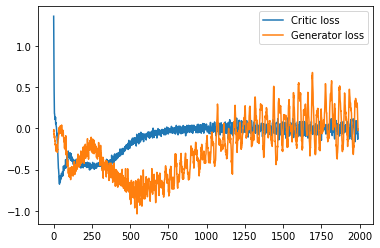

**** Iter 2000   Val ROC 0.500, AP: 0.583, EO 0.826 ****
2500   /200000   training iterations, took 321 seconds so far...


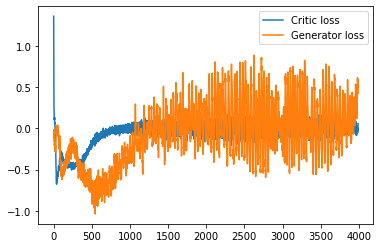

**** Iter 4000   Val ROC 0.500, AP: 0.583, EO 0.826 ****


KeyboardInterrupt: 

In [12]:
log_dict = netgan.train(A_orig=_A_obs, val_ones=val_ones, val_zeros=val_zeros, stopping=stopping,
                        eval_every=eval_every, plot_every=plot_every, max_patience=20, max_iters=200000)

In [ ]:
log_dict.keys()

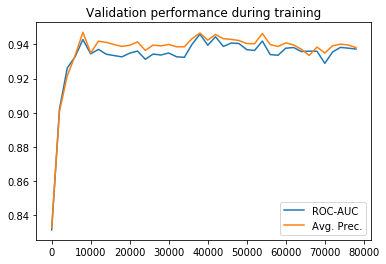

In [15]:
plt.plot(np.arange(len(log_dict['val_performances'])) * eval_every, 
         np.array(log_dict['val_performances'])[:,0], label="ROC-AUC")
plt.plot(np.arange(len(log_dict['val_performances'])) * eval_every,
         np.array(log_dict['val_performances'])[:,1], label="Avg. Prec.")

plt.title("Validation performance during training")
plt.legend()
plt.show()

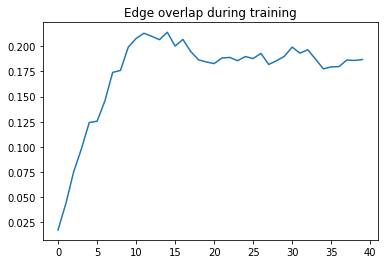

In [16]:
plt.plot(np.array(log_dict['edge_overlaps'])/_A_obs.sum())
plt.title("Edge overlap during training")
plt.show()

#### Generate random walks on the trained model

In [17]:
sample_many = netgan.generate_discrete(10000, reuse=True)

In [18]:
samples = []

In [31]:
for _ in range(6000):
    if (_+1) % 500 == 0:
        print(_)
    samples.append(sample_many.eval({netgan.tau: 0.5}))

499
999
1499
1999
2499
2999
3499
3999
4499
4999
5499
5999


#### Assemble score matrix from the random walks

In [32]:
rws = np.array(samples).reshape([-1, rw_len])
scores_matrix = utils.score_matrix_from_random_walks(rws, _N).tocsr()

#### Evaluate generalization via link prediction

In [33]:
test_labels = np.concatenate((np.ones(len(test_ones)), np.zeros(len(test_zeros))))
test_scores = np.concatenate((scores_matrix[tuple(test_ones.T)].A1, scores_matrix[tuple(test_zeros.T)].A1))

In [37]:
roc_auc_score(test_labels, test_scores)

0.9485468750000001

In [38]:
average_precision_score(test_labels, test_scores)

0.9563187636554668